# Interactive Deep Reinforcement Learning Tutorial with DQN

In this tutorial, you will learn:

1. **The Reinforcement Learning Setting:** How an agent interacts with an environment to maximize cumulative rewards.
1. **Mathematical Foundations:** The Q-learning update rule and how it extends to Deep Q-Networks.
1. **A Practical Implementation:** Building a DQN agent with PyTorch, using experience replay and a target network.
1. **Interactive Experimentation:** Train the agent, view progress plots, and evaluate performance.

## Mathematical Background

### Reinforcement Learning (RL) Basics

In RL, an **agent** interacts with an **environment** in discrete time steps. At each step:
* The agent observes a state $s$,
* Chooses an action $a$,
* Receives a reward $r$,
* And transitions to a new state $s′$.

The goal is to learn a policy that maximizes the cumulative (discounted) reward:
$$
G_t=\sum_{k=0}^{\inf}\gamma^kr_{t+k}
$$
where $\gamma$ (with $0\le\gamma\lt1$) is the discount factor.

### Q-Learning

Q-learning estimates the action-value function $Q(s,a)$ — the expected return for taking action $a$ in state $s$. The classical update rule is:
$$
Q(s,a)\leftarrow Q(s,a)+\alpha\Bigl(r+\gamma\underset{a'}{\operatorname{max}}Q(s',a')-Q(s,a)\Bigr)
$$
where $\alpha$ is the learning rate.

### Deep Q-Network (DQN)

In DQN, a neural network approximates $Q(s,a;\theta)$. The network is trained to minimize the mean-squared error between the prdicted Q-values and a target:
$$
L(\theta)=\mathbb E_{(s,a,r,s')\sim\mathcal{D}}\left[\bigl(r+\gamma\underset{a'}{\operatorname{max}}Q(s',a';\theta^-)-Q(s,a;\theta)\bigr)^2\right]
$$
Here:
* $\theta$ are the current network parameters.
* $\theta^-$ are the parameters of the **target network** (a delayed copy of the network) used to stabilize training.
* $\mathcal{D}$ is the experience replay buffer from which transitions are sampled.

## Code Implementation

### Import Libraries and Setup

In [1]:
import random
import math
import gymnasium as gym # o3: `import gym`
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Define the Replay Memory

In [2]:
# A named tuple representing a single transition in our environment.
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

### Define the Deep Q-Network (DQN)

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # A simple fully-connected network with two hidden layers.
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

### Define the DQN Agent

In [4]:
class DQNAgent:
    def __init__(self, state_space, action_space, params):
        self.n_actions = action_space.n
        self.state_dim = state_space.shape[0]
        self.batch_size = params['batch_size']
        self.gamma = params['gamma']
        self.epsilon_start = params['epsilon_start']
        self.epsilon_end = params['epsilon_end']
        self.epsilon_decay = params['epsilon_decay']
        self.learning_rate = params['learning_rate']
        self.target_update = params['target_update']
        
        self.policy_net = DQN(self.state_dim, self.n_actions).to(device)
        self.target_net = DQN(self.state_dim, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # target network in eval mode
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(params['replay_memory_capacity'])
        self.steps_done = 0
    
    def select_action(self, state):
        """Selects an action using an epsilon-greedy policy."""
        sample = random.random()
        epsilon_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
        if sample < epsilon_threshold:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                # The network returns Q-values for all actions.
                return self.policy_net(state).max(1)[1].view(1, 1)
    
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for detailed explanation)
        batch = Transition(*zip(*transitions))
        
        # Compute a mask of non-final states (i.e., states for which next_state is not None).
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Compute Q(s_t, a) - the model computes Q(s_t) for all actions.
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute V(s_{t+1}) for all next states.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch.squeeze()
        expected_state_action_values = expected_state_action_values.unsqueeze(1)
        
        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients (optional but often helps)
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

### Training Loop

In [5]:
def train_dqn(env, agent, num_episodes):
    episode_durations = []
    episode_rewards = []

    for i_episode in range(num_episodes):
        ### Originally, o3 said this, then corrected it after I shared the error:
        # state = env.reset()
        # state = torch.tensor([state], device=device, dtype=torch.float32)
        
        # Initialize the environment and state.
        state, _ = env.reset()
        state = torch.tensor([state], device=device, dtype=torch.float32)
        total_reward = 0.0
        
        for t in range(1, 10000):  # Don't infinite loop
            # Select and perform an action.
            action = agent.select_action(state)
            ### Before error correction:
            # next_state, reward, done, _ = env.step(action.item())
            ### After error correction:
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            total_reward += reward
            
            reward_tensor = torch.tensor([reward], device=device)
            if not done:
                next_state_tensor = torch.tensor([next_state], device=device, dtype=torch.float32)
            else:
                next_state_tensor = None
            
            # Store the transition in memory.
            agent.memory.push(state, action, next_state_tensor, reward_tensor)
            
            # Move to the next state.
            state = next_state_tensor if next_state_tensor is not None else None
            
            # Perform one step of the optimization (on the policy network).
            agent.optimize_model()
            if done:
                episode_durations.append(t)
                episode_rewards.append(total_reward)
                break
        
        # Update the target network, copying all weights from policy network.
        if i_episode % agent.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        # Print progress every 10 episodes.
        if (i_episode + 1) % 10 == 0:
            print(f"Episode {i_episode+1}/{num_episodes}, Duration: {t}, Total Reward: {total_reward:.2f}")
    
    print("Training complete!")
    return episode_durations, episode_rewards

### Main Execution and Plotting Results

/tmp/ipykernel_100195/1140250442.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], device=device, dtype=torch.float32)


Episode 10/200, Duration: 10, Total Reward: 10.00
Episode 20/200, Duration: 12, Total Reward: 12.00
Episode 30/200, Duration: 9, Total Reward: 9.00
Episode 40/200, Duration: 21, Total Reward: 21.00
Episode 50/200, Duration: 212, Total Reward: 212.00
Episode 60/200, Duration: 452, Total Reward: 452.00
Episode 70/200, Duration: 208, Total Reward: 208.00
Episode 80/200, Duration: 196, Total Reward: 196.00
Episode 90/200, Duration: 177, Total Reward: 177.00
Episode 100/200, Duration: 229, Total Reward: 229.00
Episode 110/200, Duration: 197, Total Reward: 197.00
Episode 120/200, Duration: 189, Total Reward: 189.00
Episode 130/200, Duration: 315, Total Reward: 315.00
Episode 140/200, Duration: 336, Total Reward: 336.00
Episode 150/200, Duration: 198, Total Reward: 198.00
Episode 160/200, Duration: 252, Total Reward: 252.00
Episode 170/200, Duration: 211, Total Reward: 211.00
Episode 180/200, Duration: 193, Total Reward: 193.00
Episode 190/200, Duration: 145, Total Reward: 145.00
Episode 200/

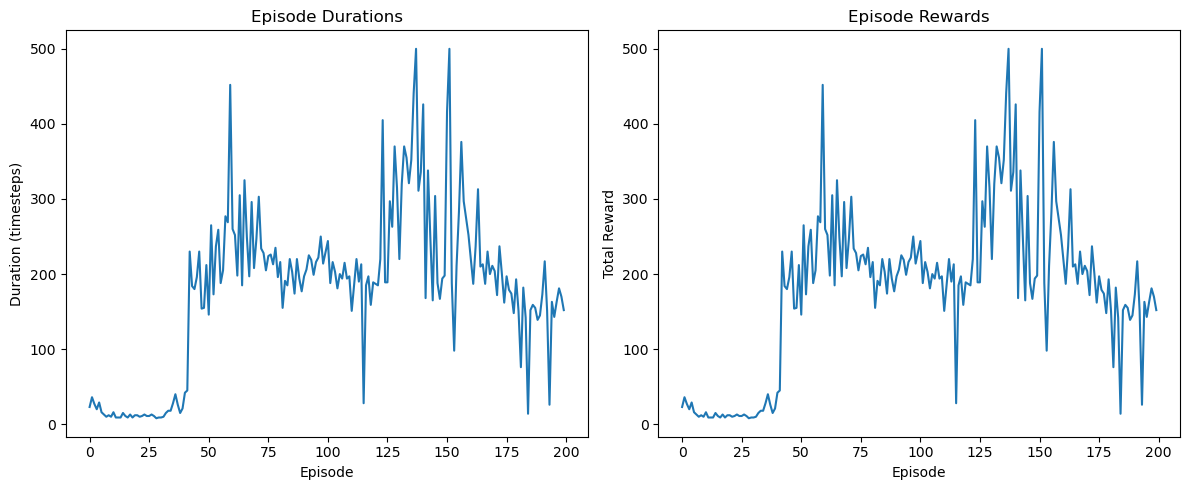

In [6]:
# Hyperparameters and parameters for the DQN
params = {
    'batch_size': 128,
    'gamma': 0.999,
    'epsilon_start': 0.9,
    'epsilon_end': 0.05,
    'epsilon_decay': 200,  # Lower value => faster decay
    'learning_rate': 1e-3,
    'target_update': 10,  # Update target network every 10 episodes
    'replay_memory_capacity': 10000,
}

# Create the environment and agent.
env = gym.make('CartPole-v1')
agent = DQNAgent(env.observation_space, env.action_space, params)

# Train the agent for a specified number of episodes.
num_episodes = 200  # Feel free to adjust this number
durations, rewards = train_dqn(env, agent, num_episodes)

# Plotting the results.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(durations)
plt.title("Episode Durations")
plt.xlabel("Episode")
plt.ylabel("Duration (timesteps)")

plt.subplot(1,2,2)
plt.plot(rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.tight_layout()
plt.show()

In [7]:
# My own cell to make a new environment for rendering below
env.close()

### Evaluate the Trained Agent

Old cell, before o3 fixed the errors mentioned above:

After the fix:

In [8]:
def run_trained_agent(env, agent, render=True):
    state, _ = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    total_reward = 0.0
    
    for t in range(1000):
        if render:
            env.render()
        with torch.no_grad():
            action = agent.policy_net(state).max(1)[1].view(1, 1)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        total_reward += reward
        state = torch.tensor([next_state], device=device, dtype=torch.float32) if not done else None
        if done:
            print(f"Episode finished after {t+1} timesteps with total reward {total_reward:.2f}")
            break

In [11]:
# run_trained_agent(env, agent, render=False) <- o3's code
env = gym.make('CartPole-v1', render_mode='human')
run_trained_agent(env, agent) # <- Me enabling rendering
env.close()

Episode finished after 156 timesteps with total reward 156.00
